# Project 3: Behavioral Cloning

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## Equipment

**Data Collection**

Data collection was performed on a 2012 Retina Macbook Pro with the following specifications:

- macOS Sierra (10.12.5)
- 2.3 Intel Core i7
- 16 GB 1600 Mhz DDR3 RAM
- NVIDIA GeForce 650M GPU
- TensorFlow (GPU) 1.1.0
- Simulator settings
  - screen resolution: (1024 x 768)
  - graphics quality: fastest

**Model Training**

Model training was performed on my local machine and on an AWS EC2 GPU instance with the following specifications:
- Type: g2.2xlarge
- 26 ECUs
- 2.6 GHz, Intel Xeon E5-2670 (8 vCPUs)
- 15 GiB memory
- 1 x 60 GiB Storage Capacity

## Files Submitted & Code Quality

**Requirement: Submission includes all required files and can be used to run the simulator in autonomous mode.**

Project folder includes the following files:
* `model.py` containing the script to create and train the model
* `drive.py` for driving the car in autonomous mode
* `model.h5` containing a trained convolution neural network 
* `writeup.html` summarizing the results

**Requirement: Submission includes functional code.**

Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing.

`python3 drive.py model.h5`

**Requirement: Submission code is usable and readable.**

The model.py file and Jupyter notebook contain the code for training and saving the convolution neural network. The files show the pipeline I used for training and validating the model, and it contain comments to explain how the code works.

## Model Architecture

**Requirement: An appropriate model architecture has been employed.**

NVIDIA architecture was used and its structure depicted under "Training Strategy."

**Requirement: Attempts to reduce overfitting in the model.**

I attempted to reduce overfitting by augmenting the recorded data. I augmented the data by using left and right images with arbitrary correction angle to simulate being off-center, and by flipping images.

I also used data from Track 2, so the model would be more generalized.

Finally, I used Keras's `ModelCheckpoint` to save the best version of the model by monitoring validation loss.

**Requirement: Model parameter tuning.**

The model used an adam optimizer, so the learning rate was not tuned manually.

** Requirement: Appropriate training data**

Training data was chosen to keep the vehicle driving on the road. I used a combination of center lane driving, recovering from the left and right sides of the road.

The images used in training the model are thresholded against the steering angle to avoid a bias toward driving straight.

The data set contains data from two forward runs of Track 1 and one forward run of Track 2.

## Training Strategy

**Requirement: Design Approach**

The overall strategy for deriving a model architecture was to first test results using a LeNet architecture, a modified LeNet architecture with added dropout layers, then the NVIDIA architecture.

I first used a convolution neural network model similar to LeNet. I started here to get a rough idea of the performance of a relatively simple neural network in navigating each track before employing a more powerful network, such as the NVIDIA architecture.

I first trained each model for one epoch to evaluation to test the results before training for additional epochs. In order to gauge how well the model was working, I split my image and steering angle data into a training and validation set. 

The NVIDIA model was not modified but the data was augmented in an effort to prevent overfitting. I also used to Keras's `ModelCheckpoint` to save the best version of the model.

The final step was to run the simulator to see how well the car was driving around Track 1. The vehicle had difficulty staying on track in sharp turns and near surface changes, for example, where the roadside surface was dirt as opposed to grass.

At the end of the process, the vehicle is able to drive autonomously around the track without leaving the road.

**Requirement: Final Model Architecture**

The final model architecture consisted of a convolution neural network, which follows the NVIDIA architecture with layers as depicted below:

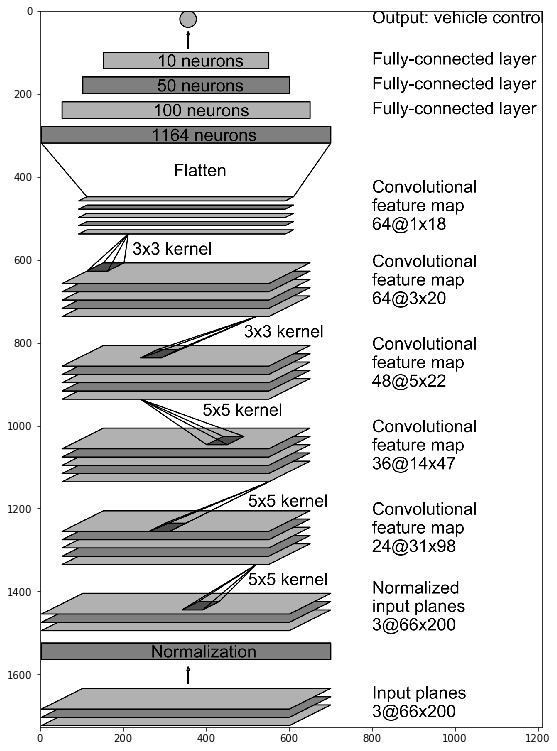

In [8]:
architecture = mpimg.imread('nvidia-architecture.png')

plt.figure(figsize=(9,16))
plt.imshow(architecture)
plt.show()

**Requirement: Creation of the Training Set & Training Process**

To capture good driving behavior, I first recorded one lap on Track 1 using center lane driving, then two laps of recovery driving.

Then I recorded driving on Track 2 in order to get additional data points.

To augment the data sat, I also flipped images and angles to create more data points and prevent the model from "memorizing" the track. Below is an example of a flipped image:

In [9]:
def flip_image(image):
    """Flip image with Open CV."""
    copy = np.copy(image)
    copy = np.fliplr(copy)
    return copy

def crop_image(image):
    """Crop image to the region of interest."""
    copy = np.copy(image)
    crop = copy[70:135, 0:320]
    return crop

def plot_example(image, augmented):
    """Convenience function for plotting 2x1 grid of images."""
    fig = plt.figure(figsize=(16,9))
        
    a = fig.add_subplot(121)
    plt.imshow(image)
    
    b = fig.add_subplot(122)
    plt.imshow(augmented)
    
    plt.show()

demo = cv2.imread('demo.jpg')
demo = cv2.cvtColor(demo, cv2.COLOR_BGR2RGB)

demo2 = cv2.imread('demo2.jpg')
demo2 = cv2.cvtColor(demo2, cv2.COLOR_BGR2RGB)

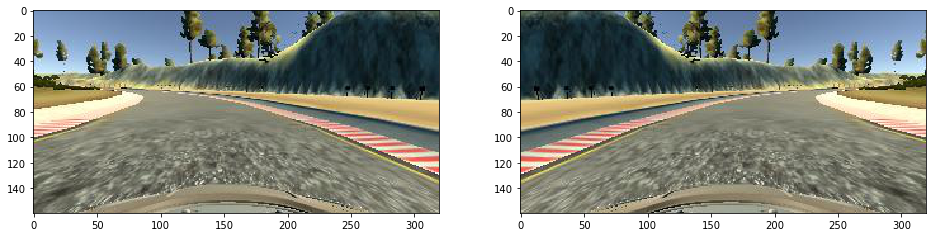

In [10]:
plot_example(demo, flip_image(demo))

Below are examples of the cropped image used in training the model.

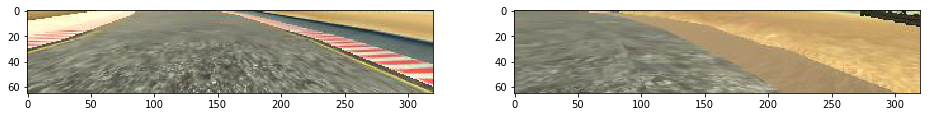

In [11]:
plot_example(crop_image(demo), crop_image(demo2))

3817 original images were used from the data set (after thresholding), and 15268 data points were used in training after augmentation of the original set. I then preprocessed this data by cropping and normalizing each image.

I randomly shuffled the data set and used 30% of the data as a validation set. 

I used the training data for training the model. The validation set helped determine if the model was over or under fitting. An adam optimizer  was used so that manually training the learning rate wasn't necessary.

# model.py

In [12]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os.path as path
import random

### Load Data ###
samples = []
totalCount = 0

def flip_image(image):
    """Flips images with OpenCV."""
    copy = np.copy(image)
    copy = np.fliplr(copy)
    return copy

def load_samples():
    """Loads recorded images from the project subfolder 'train_data'."""
    
    lines = []
    images = []
    measurements = []
  
    folders = [
                'tk1_run1',
                'tk2_run1',
               ]
    
    for folder in folders:
        with open('./train_data/{}/driving_log.csv'.format(folder)) as csvfile:
            reader = csv.reader(csvfile)
            """
            Keeps track of the number of images being used within each subfolder.
            This will be the number of images that meet the threshold requirements.
            """
            
            lineCount = 0
            
            for line in reader:
                lines.append(line)
  
        for line in lines:
            """
            Excludes images where there is a small steering angle.
            This is to prevent the model from having a bias toward straight driving.
            """
            thresh_angle = 0.0349066 # 2 degrees
            
            # Arbitrary correction factor
            correction = 0.3 # 17 degrees
            
            center_path = line[0]
            left_path = line[1]
            right_path = line[2]
                        
            center_filename = center_path.split('/')[-1]
            center_path = './train_data/{}/IMG/'.format(folder) + center_filename
            
            left_filename = left_path.split('/')[-1]
            left_path = './train_data/{}/IMG/'.format(folder) + left_filename
            
            right_filename = right_path.split('/')[-1]
            right_path = './train_data/{}/IMG/'.format(folder) + right_filename

            center_angle = float(line[3])
            
            if path.isfile(center_path) and abs(float(line[3])) >= thresh_angle:
                samples.append((center_path, center_angle, False))
                samples.append((center_path, center_angle, True)) # Boolean determines whether to flip the image
                
                lineCount += 1
            
            if path.isfile(left_path) and abs(float(line[3])) >= thresh_angle:
                left_angle = center_angle + correction
                samples.append((left_path, left_angle, False))
                                
            if path.isfile(right_path) and abs(float(line[3])) >= thresh_angle:
                right_angle = center_angle - correction
                samples.append((right_path, right_angle, False))
        
        global totalCount
        
        totalCount += lineCount
        print('Folder:',folder)
        print("{} images".format(lineCount))
                
load_samples()
print('Total original images:', totalCount)
print("Total augmesnted images: {}".format(len(samples)))
### End Load Data ###

### Generator ###
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset + int(batch_size)]
            images = []
            angles = []

            for batch_sample in batch_samples:
                img_path = batch_sample[0]
                angle = float(batch_sample[1])
                flipped = batch_sample[2]

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                if flipped:
                    image = flip_image(image)
                    angle = -angle

                assert image.shape == (160,320,3), "img %s has shape %r" % (img_path, image.shape)

                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)

            assert len(images) == len(angles), "images (%d) != angles (%d)" % (len(images), len(angles))
            yield sklearn.utils.shuffle(X_train, y_train)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.3)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
### End Generator ###

### Model Architecture ###
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time

NUM_EPOCHS = 5

model_name = 'nvidia'

def train_model():
    start = time.time()
    
    def resize_img(input):
        from keras.backend import tf as ktf
        return ktf.image.resize_images(input, (66, 200))
    
    # NVIDIA Architecture #
    model = Sequential()

    model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))

    model.add(Lambda(lambda x: x/255.0 - 0.5))
    
    model.add(Lambda(resize_img))

    model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="elu", strides=(2, 2)))
    model.add(Conv2D(64, (1, 1), activation="elu", strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    try:
        model.load_weights(model_name + '.h5')
        print('Loaded previously saved weights.')

    except:
        print('Error: could not load weights.')

    
    checkpoint = ModelCheckpoint(model_name + '.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    
    model.compile(loss='mse', optimizer='adam')
    history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                                         validation_data=validation_generator,  
                                         nb_val_samples=len(validation_samples), nb_epoch=NUM_EPOCHS, callbacks=[checkpoint])

    end = time.time()
    
    print('Time to train:', round((end-start)/60, 3), 'minutes')
    
    # Summary of model architectue
    print(model.summary())

train_model()
### End Model Architecture ###

Folder: tk1_run1
789 images
Folder: tk2_run1
710 images
Total original images: 1499
Total augmesnted images: 5996
Error: could not load weights.


/Users/lybron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/lybron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=4197, epochs=5, validation_steps=1799)`


Epoch 1/5
4197/4197 [==============================] - 690s - loss: 0.0256 - val_loss: 0.0753
Epoch 2/5
4197/4197 [==============================] - 703s - loss: 0.0045 - val_loss: 0.0704
Epoch 3/5
4197/4197 [==============================] - 903s - loss: 0.0024 - val_loss: 0.0655
Epoch 4/5
4197/4197 [==============================] - 1029s - loss: 0.0015 - val_loss: 0.0595
Epoch 5/5
4197/4197 [==============================] - 1010s - loss: 0.0011 - val_loss: 0.0580
Time to train: 72.33 minutes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 66, 200, 3)        0         
_____________________________________